In [1]:
import numpy as np
import librosa
from scipy.signal import find_peaks, savgol_filter
from scipy.ndimage import gaussian_filter1d

def multi_feature_onset_detection(y, sr, hop_length=512):
    """
    Detect onsets using multiple features and combine them using weighted voting.
    
    Parameters:
        y (np.ndarray): Audio time series
        sr (int): Sampling rate
        hop_length (int): Number of samples between frames
    
    Returns:
        onset_times (np.ndarray): Timestamps of detected onsets in seconds
        onset_strengths (np.ndarray): Strength of onset detection at each frame
    """
    
    # 1. Energy-based onset detection
    def get_energy_onsets(y, sr, hop_length):
        # Compute RMS energy
        rms = librosa.feature.rms(y=y, hop_length=hop_length)[0]
        # Compute first-order difference
        rms_diff = np.diff(rms, prepend=0)
        # Half-wave rectification
        rms_diff = np.maximum(0, rms_diff)
        return rms_diff
    
    # 2. Spectral flux onset detection
    def get_spectral_flux(y, sr, hop_length):
        # Compute STFT
        D = librosa.stft(y, hop_length=hop_length)
        # Compute magnitude spectrum
        mag = np.abs(D)
        # Compute spectral flux
        flux = np.sum(np.diff(mag, axis=1, prepend=0), axis=0)
        # Half-wave rectification
        flux = np.maximum(0, flux)
        return flux
    
    # 3. Phase deviation onset detection
    def get_phase_deviation(y, sr, hop_length):
        # Compute STFT
        D = librosa.stft(y, hop_length=hop_length)
        # Compute phase
        phase = np.angle(D)
        # Calculate phase difference
        phase_diff = np.diff(phase, axis=1, prepend=0)
        # Sum across frequencies
        phase_dev = np.sum(np.abs(phase_diff), axis=0)
        return phase_dev
    
    # 4. Complex domain onset detection
    def get_complex_domain_onsets(y, sr, hop_length):
        # Compute STFT
        D = librosa.stft(y, hop_length=hop_length)
        # Compute magnitude and phase
        mag = np.abs(D)
        phase = np.angle(D)
        
        # Predict the next frame's complex spectrum
        mag_prediction = mag[:, :-1]
        phase_prediction = 2 * phase[:, 1:] - phase[:, :-1]
        
        # Calculate complex domain deviation
        prediction = mag_prediction * np.exp(1j * phase_prediction)
        actual = D[:, 1:]
        deviation = np.sum(np.abs(actual - prediction), axis=0)
        # Pad to match length
        deviation = np.pad(deviation, (1, 0))
        return deviation
    
    # Get all onset detection functions
    energy_onsets = get_energy_onsets(y, sr, hop_length)
    spectral_flux = get_spectral_flux(y, sr, hop_length)
    phase_dev = get_phase_deviation(y, sr, hop_length)
    complex_onsets = get_complex_domain_onsets(y, sr, hop_length)
    
    # Normalize each detection function
    def normalize_detection(det):
        det = (det - np.mean(det)) / np.std(det)
        return gaussian_filter1d(det, sigma=1)
    
    energy_onsets = normalize_detection(energy_onsets)
    spectral_flux = normalize_detection(spectral_flux)
    phase_dev = normalize_detection(phase_dev)
    complex_onsets = normalize_detection(complex_onsets)
    
    # Combine detection functions with weights
    weights = {
        'energy': 1.0,
        'flux': 1.2,
        'phase': 0.8,
        'complex': 1.0
    }
    
    combined_detection = (
        weights['energy'] * energy_onsets +
        weights['flux'] * spectral_flux +
        weights['phase'] * phase_dev +
        weights['complex'] * complex_onsets
    )
    
    # Smooth the combined detection function
    combined_detection = savgol_filter(combined_detection, 5, 2)
    
    # Find peaks in the combined detection function
    peaks, properties = find_peaks(
        combined_detection,
        distance=int(sr/(hop_length * 8)),  # Minimum distance between peaks
        prominence=0.5,  # Minimum prominence of peaks
        height=np.mean(combined_detection)  # Minimum height of peaks
    )
    
    # Convert frame indices to time
    onset_times = librosa.frames_to_time(peaks, sr=sr, hop_length=hop_length)
    onset_strengths = properties['peak_heights']
    
    return onset_times, onset_strengths, combined_detection

def get_beat_candidates(onset_times, onset_strengths, sr):
    """
    Convert onset detections to beat candidates using dynamic selection.
    
    Parameters:
        onset_times (np.ndarray): Timestamps of detected onsets
        onset_strengths (np.ndarray): Strength of each onset
        sr (int): Sampling rate
    
    Returns:
        beat_times (np.ndarray): Timestamps of predicted beats
    """
    # Calculate inter-onset intervals
    ioi = np.diff(onset_times)
    
    # Estimate tempo from IOIs
    def estimate_tempo(ioi, strengths):
        if len(ioi) == 0:
            return 120  # Default tempo if no IOIs
            
        # Calculate weights as average of adjacent onset strengths
        weights = (strengths[:-1] + strengths[1:]) / 2
        
        # Weight IOIs by onset strengths
        weighted_iois = ioi * weights
        
        # Convert to BPM
        bpms = 60 / weighted_iois
        
        # Filter to reasonable BPM range
        valid_bpms = bpms[(bpms >= 50) & (bpms <= 200)]
        if len(valid_bpms) == 0:
            return 120  # Default tempo if no valid BPM found
        
        # Return median tempo
        return np.median(valid_bpms)
    
    tempo = estimate_tempo(ioi, onset_strengths)
    beat_period = 60 / tempo
    
    # Select strong onsets as beat candidates
    threshold = np.mean(onset_strengths) + 0.5 * np.std(onset_strengths)
    strong_beats = onset_times[onset_strengths > threshold]
    
    if len(strong_beats) == 0:
        # If no strong beats found, use regular intervals
        total_duration = onset_times[-1] - onset_times[0]
        return np.arange(onset_times[0], onset_times[-1], beat_period)
    
    # Refine beat positions using tempo information
    def refine_beats(strong_beats, beat_period):
        # Initialize beat positions
        beats = [strong_beats[0]]
        expected_next = beats[0] + beat_period
        
        for beat in strong_beats[1:]:
            # If this beat is close to expected position, use it
            if abs(beat - expected_next) < beat_period * 0.3:
                beats.append(beat)
                expected_next = beat + beat_period
            # If we've missed some beats, interpolate
            elif beat > expected_next + beat_period * 0.3:
                while expected_next < beat - beat_period * 0.3:
                    beats.append(expected_next)
                    expected_next += beat_period
                beats.append(beat)
                expected_next = beat + beat_period
        
        return np.array(beats)
    
    beat_times = refine_beats(strong_beats, beat_period)
    
    return beat_times

def improved_beat_tracking(y, sr):
    """
    Main function for improved beat tracking using multi-feature onset detection.
    
    Parameters:
        y (np.ndarray): Audio time series
        sr (int): Sampling rate
    
    Returns:
        beat_times (np.ndarray): Timestamps of detected beats
        tempo (float): Estimated tempo in BPM
    """
    # Get onset times and strengths
    onset_times, onset_strengths, detection_curve = multi_feature_onset_detection(y, sr)
    
    # Convert onsets to beats
    beat_times = get_beat_candidates(onset_times, onset_strengths, sr)
    
    # Calculate tempo from beat times
    if len(beat_times) > 1:
        tempo = float(60 / np.median(np.diff(beat_times)))
    else:
        tempo = 120.0  # Default tempo if insufficient beats detected
    
    return beat_times, tempo

/tmp/ipykernel_6531/899371921.py:92: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


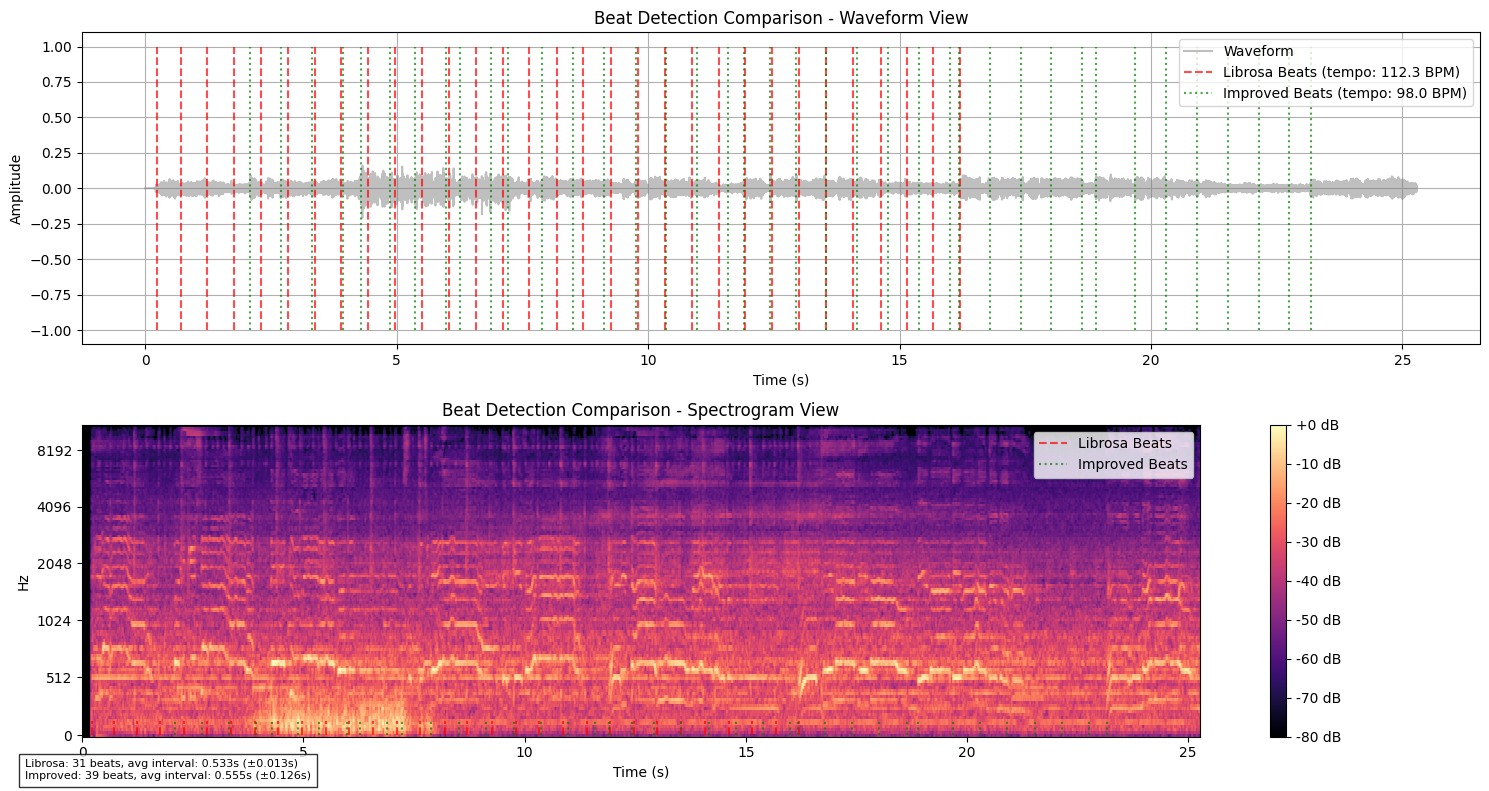

In [6]:
# y, sr = librosa.load("infer2.mp3")
    
#     # Replace librosa.beat.beat_track with improved beat tracking
# beat_times, tempo = improved_beat_tracking(y, sr)
import matplotlib.pyplot as plt

def plot_beat_comparison(audio_file):
    """
    Plot and compare beat tracking results from librosa and improved method
    
    Parameters:
        audio_file (str): Path to audio file
    """
    # Load audio file
    y, sr = librosa.load(audio_file)
    
    # Get beats using librosa
    tempo_librosa, beats_librosa = librosa.beat.beat_track(y=y, sr=sr)
    beats_times_librosa = librosa.frames_to_time(beats_librosa, sr=sr)
    
    # Get beats using improved method
    beats_times_improved, tempo_improved = improved_beat_tracking(y, sr)
    
    # Ensure tempo is a single float value
    if isinstance(tempo_improved, np.ndarray):
        tempo_improved = float(np.median(tempo_improved))
    
    # Create time array for x-axis
    times = np.linspace(0, len(y)/sr, len(y))
    
    # Plot configuration
    plt.figure(figsize=(15, 8))
    
    # Plot waveform
    plt.subplot(2, 1, 1)
    plt.plot(times, y, color='gray', alpha=0.5, label='Waveform')
    
    # Plot librosa beats
    plt.vlines(beats_times_librosa, -1, 1, color='r', 
               label=f'Librosa Beats (tempo: {float(tempo_librosa[0]):.1f} BPM)',
               linestyles='dashed', alpha=0.7)
    
    # Plot improved beats
    plt.vlines(beats_times_improved, -1, 1, color='g', 
           label=f'Improved Beats (tempo: {np.asscalar(tempo_improved) if isinstance(tempo_improved, np.ndarray) else float(tempo_improved):.1f} BPM)',
           linestyles='dotted', alpha=0.7)
    
    plt.title('Beat Detection Comparison - Waveform View')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    
    # Plot spectrogram with beats
    plt.subplot(2, 1, 2)
    
    # Compute mel spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    # Plot spectrogram
    librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    
    # Plot librosa beats
    plt.vlines(beats_times_librosa, 0, mel_spec.shape[0], color='r', 
               label=f'Librosa Beats', linestyles='dashed', alpha=0.7)
    
    # Plot improved beats
    plt.vlines(beats_times_improved, 0, mel_spec.shape[0], color='g',
               label=f'Improved Beats', linestyles='dotted', alpha=0.7)
    
    plt.title('Beat Detection Comparison - Spectrogram View')
    plt.xlabel('Time (s)')
    plt.legend()
    
    # Calculate and display some statistics
    avg_librosa_interval = np.mean(np.diff(beats_times_librosa))
    std_librosa_interval = np.std(np.diff(beats_times_librosa))
    avg_improved_interval = np.mean(np.diff(beats_times_improved))
    std_improved_interval = np.std(np.diff(beats_times_improved))
    
    stats_text = (
        f'Librosa: {len(beats_times_librosa)} beats, '
        f'avg interval: {avg_librosa_interval:.3f}s (±{std_librosa_interval:.3f}s)\n'
        f'Improved: {len(beats_times_improved)} beats, '
        f'avg interval: {avg_improved_interval:.3f}s (±{std_improved_interval:.3f}s)'
    )
    
    plt.figtext(0.02, 0.02, stats_text, fontsize=8, bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    return plt


if __name__ == "__main__":
    # Example usage
    audio_file = "infer3.mp3"  # Replace with your audio file
    plt = plot_beat_comparison(audio_file)
    plt.show()